In [ ]:
# Importing Libraries

import librosa
import librosa.display
from librosa import feature

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pathlib
import os

from PIL import Image 

from sklearn import preprocessing
from sklearn.metrics import  classification_report,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

# from scipy.io import wavfile as wav
# warnings.filterwarnings('ignore')

In [ ]:
from google.colab import  drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DATA_PATH = 'gdrive/My Drive/Audio_Speech_Actors_01-24/'
emotions = ['neutral','calm','happy','sad','angry','fearful','disgust','surprised']
mylist = os.listdir(DATA_PATH)
print('Total Number of Actors: ',len(mylist))


Total Number of Actors:  24


In [ ]:
# Create a Dataframe that stores the details of the audio, stored in the Filename

new_df = pd.DataFrame(columns=['path','actor','gender','intensity','emotion','emotion_lbl'])
count= 0

for folder in os.listdir(DATA_PATH):
    directory = DATA_PATH+folder
    for audio_file in os.listdir(directory):
        file_path = directory +'/'+ audio_file
        nm = audio_file.split('.')[0].split('-')
        path = file_path
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"

        if nm[3] == '01':
            intensity = 'normal'
        else:
            intensity = 'strong'

        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
            
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1

        if emotion == 1:
            lb = "neutral"
        elif emotion == 2:
            lb = "calm"
        elif emotion == 3:
            lb = "happy"
        elif emotion == 4:
            lb = "sad"
        elif emotion == 5:
            lb = "angry"
        elif emotion == 6:
            lb = "fearful"
        elif emotion == 7:
            lb = "disgust"
        elif emotion == 8:
            lb = "surprised"
        else:
            lb = "none"

        new_df.loc[count] = [path,actor, gender, intensity,emotion,lb]
        count += 1
new_df.sort_values(by='path',inplace=True)
new_df.index =  range(len(new_df.index))
print('The shape of the New Data frame is:',new_df.shape)

The shape of the New Data frame is: (1440, 6)


## **Understanding the Original Dataset**


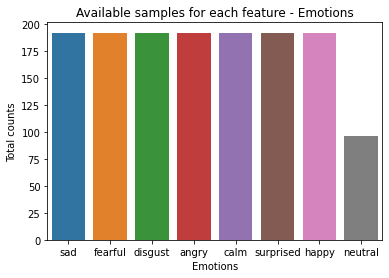

In [ ]:
# Check the availabe samples for each feature with respect to Emotions

values = new_df.emotion_lbl.value_counts().reset_index()
values
sns.barplot(x= values['index'],y=values.emotion_lbl)
plt.xlabel('Emotions')
plt.ylabel('Total counts')
plt.title('Available samples for each feature - Emotions')
plt.show()

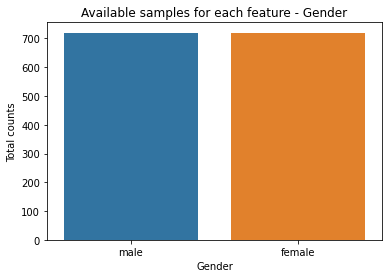

In [ ]:
# Check the availabe samples for each feature with respect to Gender

values = new_df.gender.value_counts().reset_index()
values
sns.barplot(x= values['index'],y=values.gender)
plt.xlabel('Gender')
plt.ylabel('Total counts')
plt.title('Available samples for each feature - Gender')
plt.show()

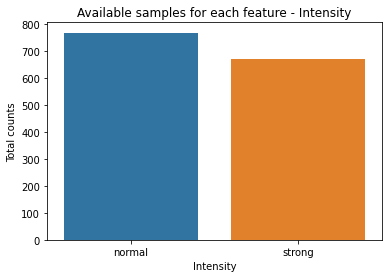

In [ ]:
# Check the availabe samples for each feature with respect to Intensity

values = new_df.intensity.value_counts().reset_index()
values
sns.barplot(x= values['index'],y=values.intensity)
plt.xlabel('Intensity')
plt.ylabel('Total counts')
plt.title('Available samples for each feature - Intensity')
plt.show()

From the visualisations, the dataset looks balanced. So Confusion Matrix, Accuracy can be used as Performance metrics

In [ ]:
angry_path = list(new_df[(new_df.emotion_lbl=='angry')&(new_df.gender=='male')]['path'])[10]
disgust_path = list(new_df[(new_df.emotion_lbl=='disgust')&(new_df.gender=='male')]['path'])[10]
neutral_path = list(new_df[(new_df.emotion_lbl=='neutral')&(new_df.gender=='male')]['path'])[10]
sad_path = list(new_df[(new_df.emotion_lbl=='sad')&(new_df.gender=='male')]['path'])[10]
surprised_path = list(new_df[(new_df.emotion_lbl=='surprised')&(new_df.gender=='male')]['path'])[10]
fearful_path = list(new_df[(new_df.emotion_lbl=='fearful')&(new_df.gender=='male')]['path'])[10]
happy_path = list(new_df[(new_df.emotion_lbl=='happy')&(new_df.gender=='male')]['path'])[10]
calm_path = list(new_df[(new_df.emotion_lbl=='calm')&(new_df.gender=='male')]['path'])[10]

print("Angry:\t",angry_path)
print('Disgust: ',disgust_path)
print('Neutral: ',neutral_path)
print('Sad: ',sad_path)
print('Surprise: ',surprised_path)
print('Fear: ',fearful_path)
print('Happy: ',happy_path)
print('Calm: ',calm_path)
emotion_list = ['Angry','Disgust','Neutral','Sad','Surprised','Fearful','Happy','Calm']
path_list = [angry_path,disgust_path,neutral_path,sad_path,surprised_path,fearful_path,happy_path,calm_path]

Angry:	 gdrive/My Drive/Colab Notebooks/Audio_Speech_Actors_01-24/Actor_03/03-01-05-01-02-01-03.wav
Disgust:  gdrive/My Drive/Colab Notebooks/Audio_Speech_Actors_01-24/Actor_03/03-01-07-01-02-01-03.wav
Neutral:  gdrive/My Drive/Colab Notebooks/Audio_Speech_Actors_01-24/Actor_05/03-01-01-01-02-01-05.wav
Sad:  gdrive/My Drive/Colab Notebooks/Audio_Speech_Actors_01-24/Actor_03/03-01-04-01-02-01-03.wav
Surprise:  gdrive/My Drive/Colab Notebooks/Audio_Speech_Actors_01-24/Actor_03/03-01-08-01-02-01-03.wav
Fear:  gdrive/My Drive/Colab Notebooks/Audio_Speech_Actors_01-24/Actor_03/03-01-06-01-02-01-03.wav
Happy:  gdrive/My Drive/Colab Notebooks/Audio_Speech_Actors_01-24/Actor_03/03-01-03-01-02-01-03.wav
Calm:  gdrive/My Drive/Colab Notebooks/Audio_Speech_Actors_01-24/Actor_03/03-01-02-01-02-01-03.wav


In [ ]:
# Calculate MFCCs, MelSpectrogram and Mean Mel Spectrogram
def calculate_mel_mfcc(path):
    
    end_list = []
    
    sample, sample_rate = librosa.load(path, res_type='kaiser_fast',sr=22050*2)  
    sample, index = librosa.effects.trim(sample,top_db=25)
    sample =  scipy.signal.wiener(sample)

    path_mfcc = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=20)
    mean_path_MFCC = np.mean(librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=20), axis=0)

    S_sample = librosa.feature.melspectrogram(sample, sr=sample_rate, n_mels=128,n_fft=2048,hop_length=512)
    path_Mel = librosa.amplitude_to_db(S_sample, ref=np.max)
    end_list = [path_mfcc,mean_path_MFCC,path_Mel]
    
    return end_list

melval_list = []
for path in path_list: 
    melval_list.append(calculate_mel_mfcc(path))

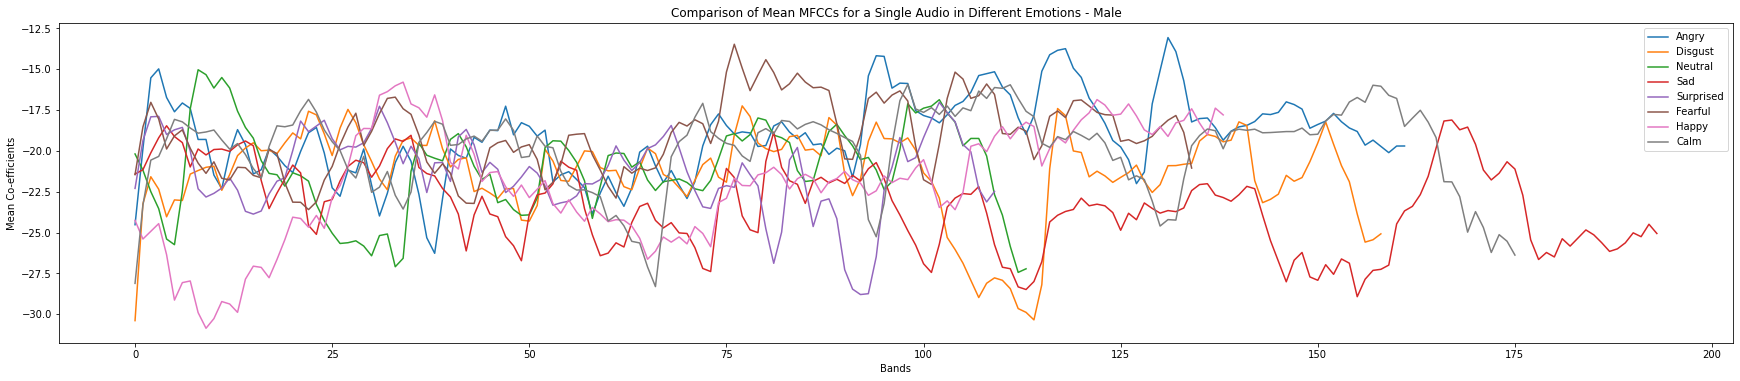

In [ ]:
# Audio Waves - Male
plt.figure(figsize=(30, 20))
plt.subplot(3,1,1)
for i in range(0,len(melval_list)):
    plt.plot(melval_list[i][1], label='{}'.format(emotion_list[i]))
# plt.plot(mean_male_MFCC, label='male')
plt.title('Comparison of Mean MFCCs for a Single Audio in Different Emotions - Male')
plt.xlabel('Bands')
plt.ylabel('Mean Co-efficients')
plt.legend()



## **Data Preparation -** **Generate Mel Spectograms**

In [ ]:

def create_emotion_folder(emotion,audio_file):
    folder = f'Spectograms/'
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    audio_info, samplerate = librosa.load(audio_file,mono=True,duration=2.5)
    ps = librosa.feature.melspectrogram(y=audio_info,sr=samplerate)
    librosa.display.specshow(librosa.power_to_db(ps,ref=np.max))
    plt.savefig(f'Spectograms/{audio[:-3].replace(".","")}.png',bbox_inches='tight',transparent=True, pad_inches=-0.05)
    plt.clf()

In [ ]:
# Converting audio file into Spectogram in PNG Format.

cmap = plt.get_cmap('inferno')

emotions_map = {'01':'neutral','02':'calm','03':'happy','04':'sad','05':'angry','06':'fearful','07':'disgust','08':'surprised'}

pathlib.Path(f'Spectograms/').mkdir(parents=True,exist_ok=True)
for actor in os.listdir(DATA_PATH):
    # actor = actor.decode('utf-8')
    file_path = DATA_PATH+actor
    # print(file_path)
    
    for audio in os.listdir(file_path):
        audio_file_name = audio
        
        emo_number = audio_file_name.split('.')[0].split('-')[2]

        if (emo_number == '01'):
            emotion = emotions_map.get(emo_number)
            audio_file =file_path+'/'+audio_file_name
            create_emotion_folder(emotion,audio_file)
            
        if (emo_number == '02'):
            emotion = emotions_map.get(emo_number)
            audio_file = file_path+'/'+audio_file_name
            create_emotion_folder(emotion,audio_file)
            
        if (emo_number == '03'):
            emotion = emotions_map.get(emo_number)
            audio_file = file_path+'/'+audio_file_name
            create_emotion_folder(emotion,audio_file)
            
        if (emo_number == '04'):
            emotion = emotions_map.get(emo_number)
            audio_file = file_path+'/'+audio_file_name
            create_emotion_folder(emotion,audio_file)
            
        if (emo_number == '05'):
            emotion = emotions_map.get(emo_number)
            audio_file = file_path+'/'+audio_file_name
            create_emotion_folder(emotion,audio_file)
            
        if (emo_number == '06'):
            emotion = emotions_map.get(emo_number)
            audio_file = file_path+'/'+audio_file_name
            create_emotion_folder(emotion,audio_file)
            
        if (emo_number == '07'):
            emotion = emotions_map.get(emo_number)
            audio_file = file_path+'/'+audio_file_name
            create_emotion_folder(emotion,audio_file)
            
        if (emo_number == '08'):
            emotion = emotions_map.get(emo_number)
            audio_file = file_path+'/'+audio_file_name
            create_emotion_folder(emotion,audio_file)


<Figure size 432x288 with 0 Axes>

MEL spectrogram shape:  (128, 563)


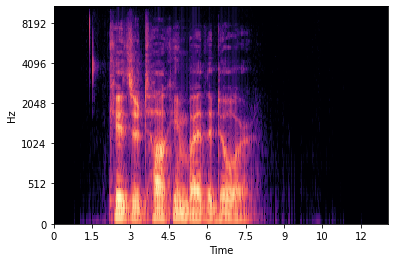

In [ ]:
# Convert audio files into spectograms 

samplerate = 48000
def generate_melspectograms(audio,samplerate):
    spec_sample = librosa.feature.melspectrogram(audio,sr=sample_rate,n_mels=128,win_length=512,
                                                 n_fft=1024,hop_length=256,window='hamming',
                                                fmax=samplerate/2)
    mel_specs = librosa.power_to_db(spec_sample,ref=np.max)
    
    return mel_specs

# test function 
# Showing how a sample spectogram would look like
audio, sample_rate = librosa.load(new_df.loc[0,'path'], duration=3, offset=0.5,sr=samplerate)
signal = np.zeros((int(samplerate*3,)))
signal[:len(audio)] = audio
mel_spectrogram = generate_melspectograms(signal, samplerate)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')

print('MEL spectrogram shape: ',mel_spectrogram.shape)


## **Data Augmentation:**
Since our database has only 1440 images. We tried to augment the data and increase the total number of samples by inducing different parameters that would add noise to the data. This would increase the training samples and train the model on variety of parameters.

In [ ]:
# Function to induce white noise
def noise(x):
    noise_amp = 0.05*np.random.uniform()*np.amax(x)   
    x = x.astype('float64') + noise_amp * np.random.normal(size=x.shape[0])
    return x

# Function to stretch the sound file
def stretch(x, rate=0.8):
    data = librosa.effects.time_stretch(x, rate)
    return data

# Function to increase the Speed and Pitch
def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change 
    tmp = np.interp(np.arange(0,len(x),speed_fac),np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x *= 0
    x[0:minlen] = tmp[0:minlen]
    return x

In [ ]:
# ADD NOISE AND USE FEATURE EXTRACTION

# df_noise = pd.DataFrame(columns=['feature'])
# counter=0
pathlib.Path(f'samples/').mkdir(parents=True,exist_ok=True)

print('Generating  Mel Spectograms')

print('Adding Noise to the Audio files.')
for path in new_df.path:
    img_name = path.split('/')[-1].replace('.wav','')
    
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=samplerate,offset=0.5)
    # noise 
    noises = noise(X)
    db_spec_noise = generate_melspectograms(noises,sample_rate)
    librosa.display.specshow(db_spec_noise, y_axis='mel', x_axis='time')
    plt.savefig(f'Spectograms/'+img_name+'_noise.png',bbox_inches='tight',transparent=True, pad_inches=-0.05)
    plt.clf()

print('Adding Stretch to the Audio.')
for index,path in enumerate(new_df.path):
    img_name = path.split('/')[-1].replace('.wav','')
    
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=samplerate,offset=0.5)
#   Stretch
    stretchs = stretch(X)
    db_spec_stretch = generate_melspectograms(stretchs,sample_rate)
    librosa.display.specshow(db_spec_stretch, y_axis='mel', x_axis='time')
    plt.savefig('Spectograms/'+img_name+'_stretch.png',bbox_inches='tight',transparent=True, pad_inches=-0.05)
    plt.clf()

print('Modulating Speed and Pitch of the Audio.')
for index,path in enumerate(new_df.path):
    img_name = path.split('/')[-1].replace('.wav','')
    
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=samplerate,offset=0.5)
#   Speech and Pitch
    snp = speedNpitch(X)
    db_spec_snp = generate_melspectograms(snp,sample_rate)
    librosa.display.specshow(db_spec_snp, y_axis='mel', x_axis='time')
    plt.savefig('samples/'+img_name+'_snp.png',bbox_inches='tight',transparent=True, pad_inches=-0.05)
    plt.clf()

    

Generating  Mel Spectograms
Adding Noise to the Audio files.
Adding Stretch to the Audio.


<Figure size 432x288 with 0 Axes>

In [ ]:
final_df = pd.DataFrame(columns=['path','actor','gender','intensity','emotions'])
# shuffled_frame = final_df.sample(frac=3.5)
network = np.array(('Spectograms/',))
counter =0
for data_path in network:
    dir_list = os.listdir(data_path)
    dir_list.sort()
    for f in os.listdir(data_path):
        f = f.decode('UTF-8')

        nm = f.split('.')[0].split('-')
        path = data_path  + f
        src = int(nm[1])
        actor = nm[-1]
        emotion = int(nm[2])

        if "_" in actor:
          actor = actor.split('_')[0]
        else:
          actor = int(actor)

        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"

        if nm[3] == '01':
            intensity = 'normal'
        else:
            intensity = 'strong'

        if nm[4] == '01':
            statement = 0
        else:
            statement = 1

        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1

        if emotion == 1:
            lb = "neutral"
        elif emotion == 2:
            lb = "calm"
        elif emotion == 3:
            lb = "happy"
        elif emotion == 4:
            lb = "sad"
        elif emotion == 5:
            lb = "angry"
        elif emotion == 6:
            lb = "fearful"
        elif emotion == 7:
            lb = "disgust"
        elif emotion == 8:
            lb = "surprised"
        else:
            lb = "none"

        final_df.loc[counter] = [path,actor, gender, intensity,lb]
        counter += 1

In [ ]:
shuffled_frame = final_df.sample(frac=1,replace=True).reset_index(drop=True)
print('Number of files generated: ',shuffled_frame.shape[0])

shuffled_frame.to_csv('./Shuffled_frame.csv')

In [ ]:
# Loading Images
input_tensor = []

data_transforms = transforms.Compose([
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        # transforms.Normalize([0.485,], [0.229,])
        ])

for image_path in shuffled_frame.path:
    img = Image.open(image_path) 
    transformed_img= data_transforms(img)
    input_tensor.append(transformed_img)


In [ ]:
input_tensor[0].shape

torch.Size([4, 128, 128])

In [ ]:
### converting dependent variable to one-hot encoding vectors
num_emotions = len(emotions)
print(emotions)
# binarizer - converts emotion into (0,1) format so expected angry to look as [0,0,0,0,1,0,0,0]
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in shuffled_frame[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())


['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']


In [ ]:
target_tensor[0].shape

(8,)

## Training and Testing Datasets

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.25)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(3240, 3240, 540, 540, 540, 540)

In [ ]:
# Shape of a single training tensor
input_tensor_train[0].shape

torch.Size([4, 128, 128])

In [ ]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 128
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE
print(TRAIN_N_BATCH,VAL_N_BATCH,TEST_N_BATCH)
embedding_dim = 256
units = 1024
target_size = num_emotions

25 4 4


In [ ]:
input_tensor_train = np.stack(input_tensor_train,axis=0)
input_tensor_val = np.stack(input_tensor_val,axis=0)
input_tensor_test = np.stack(input_tensor_test,axis=0)


In [ ]:
# Shape of the training dataset
input_tensor_train.shape

(3240, 4, 128, 128)

In [ ]:
# converting the input data to tensors and pass to the Dataloader creating a batch iterator

class MyData(Dataset):
    
    def __init__(self, X, y):
        self.data = X
        self.target = y
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    
    def __len__(self):
        return len(self.data)
   
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [ ]:
# Calculate Accuracy of each training epoch

def model_accuracy(y_pred,y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    target = torch.max(y_test,1)[1]
    correct_pred = (y_pred_tags == target).float()
    accuracy = correct_pred.sum() / len(correct_pred)
    
    accuracy = torch.round(accuracy * 100)
    
    return accuracy

# **CNN Architecture**: 
The model is built to have 3 Convolution Layers and a Fully Connected Layer. Each convolution layer has a Convolution 2D layer with a ReLu Activation Layer, Max Pooling and Dropout layer to control model overfitting. 

**Reference to the Model**: Class and Assignments

## Building the Model

In [ ]:
# BASE MODEL
class ConvNet(nn.Module):
    def __init__(self,num_classes):
        super(ConvNet,self).__init__()
        self.conv_layer = nn.Sequential(
            
#             Conv block - 01
            nn.Conv2d(4, 32, kernel_size=5, stride=1, padding=2),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(p=0.5),

#             Conv block -02
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(p=0.5),         
         
#             Conv block -03
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(p=0.5)
        )

        self.drop_out = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear( 16* 16 * 128, 500)
        self.fc2 = nn.Linear(500, num_classes)
        
        
    def forward(self,x):
        out = self.conv_layer(x)
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.drop_out(out)
        out = self.fc2(out)
        
        return out

## Training the Model

In [ ]:
# Train the Model
learning_rate = 0.0001
num_epochs = 100
weight_decay = 0.01
num_of_emotions = 8

# Enable cuda
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
print('The device in use {}'.format(device))
model = ConvNet(num_of_emotions)
model.to(device)

losses = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

total_step = len(train_loader)
loss_list = []
acc_list = []

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

for epoch in range(num_epochs):
    
#     TRAINING PHASE

    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for i, (images,labels) in enumerate(train_loader):
        X_train , y_train = images.to(device), labels.to(device)

        # Run the forward pass
        y_train_pred = model(X_train)
        train_loss = losses(y_train_pred, torch.max(y_train,1)[1])
        loss_list.append(train_loss.item())

        # Backprop and perform Adam optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # Track the accuracy
        train_acc = model_accuracy(y_train_pred,y_train)

        acc_list.append(train_acc.item())
        train_epoch_acc += train_acc.item()
        train_epoch_loss += train_loss.item()

#     VALIDATION PHASE

    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        # Evaluate the model
        model.eval()
        for images,labels in val_loader:
            
            X_val,y_val = images.to(device),labels.to(device)
            y_val_pred = model(X_val)
            # Track the model accuracy and loss
            val_loss = losses(y_val_pred, torch.max(y_val,1)[1])
            val_acc = model_accuracy(y_val_pred,y_val)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

# Generating a combine output lists for training and validation phase results
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))

# Printing Epoch results 
    print('Epoch [{}/{}]: | Step [{}/{}] | Train Loss: {:.5f} | Val Loss: {:.5f} | Train Acc: {:.3f} | Val Acc: {:.3f}'
            .format(epoch+1,num_epochs, i+1, total_step, (train_epoch_loss/len(train_loader)),
                   (val_epoch_loss/len(val_loader)), (train_epoch_acc/len(train_loader)), (val_epoch_acc/len(val_loader))))

The device in use cuda
Epoch [1/100]: | Step [25/25] | Train Loss: 6.70423 | Val Loss: 2.17410 | Train Acc: 13.800 | Val Acc: 12.500
Epoch [2/100]: | Step [25/25] | Train Loss: 2.41803 | Val Loss: 2.07441 | Train Acc: 19.760 | Val Acc: 15.500
Epoch [3/100]: | Step [25/25] | Train Loss: 2.13640 | Val Loss: 2.00668 | Train Acc: 24.600 | Val Acc: 18.750
Epoch [4/100]: | Step [25/25] | Train Loss: 2.05571 | Val Loss: 1.92954 | Train Acc: 29.320 | Val Acc: 22.500
Epoch [5/100]: | Step [25/25] | Train Loss: 1.97067 | Val Loss: 2.05667 | Train Acc: 30.400 | Val Acc: 21.250
Epoch [6/100]: | Step [25/25] | Train Loss: 1.90911 | Val Loss: 2.06339 | Train Acc: 32.440 | Val Acc: 20.750
Epoch [7/100]: | Step [25/25] | Train Loss: 1.89152 | Val Loss: 1.80027 | Train Acc: 33.640 | Val Acc: 29.500
Epoch [8/100]: | Step [25/25] | Train Loss: 1.80681 | Val Loss: 1.93095 | Train Acc: 36.760 | Val Acc: 25.250
Epoch [9/100]: | Step [25/25] | Train Loss: 1.79209 | Val Loss: 1.87329 | Train Acc: 38.080 | Val

## Plot Training Results

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

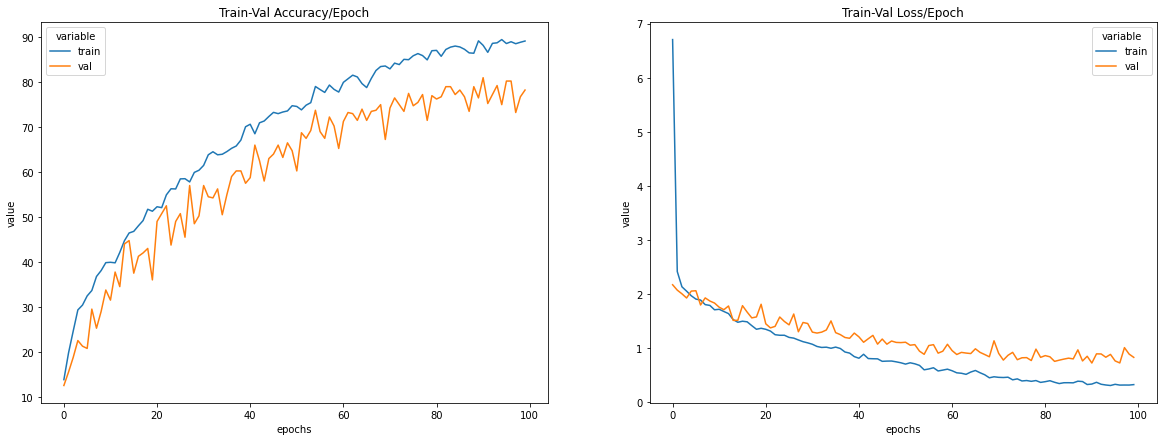

In [ ]:
# Visualize Loss and Accuracy
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## Testing the Model

In [ ]:
# Test the Model
y_pred_list = []
y_test = []
with torch.no_grad():
    model.eval()
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        target = y_batch.to(device)
        y_test.append([x.tolist().index(1) for x in target])
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

y_testing,y_prediction = [],[]
for i in y_test:
  for one in i:
    y_testing.append(one)
for i in y_pred_list:
  for x in i:
    y_prediction.append(x)


## Evaluation Metrics

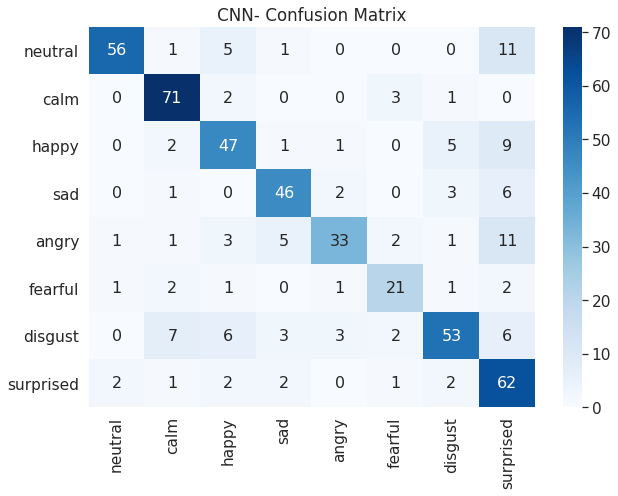

Accuracy Score:  0.759765625
Classification Report :
               precision    recall  f1-score   support

           0       0.93      0.76      0.84        74
           1       0.83      0.92      0.87        77
           2       0.71      0.72      0.72        65
           3       0.79      0.79      0.79        58
           4       0.82      0.58      0.68        57
           5       0.72      0.72      0.72        29
           6       0.80      0.66      0.73        80
           7       0.58      0.86      0.69        72

    accuracy                           0.76       512
   macro avg       0.77      0.75      0.76       512
weighted avg       0.78      0.76      0.76       512



In [ ]:

# EVALUATION METRICS

# Confusion Matrix
emotion = ['neutral','calm','happy','sad','angry','fearful','disgust','surprised']
cm = confusion_matrix(y_testing, y_prediction)
confusion_matrix_df = pd.DataFrame(cm)
names = [emotion[ind] for ind in range(len(emotion))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues').set_title('CNN- Confusion Matrix') # font size
plt.show()

# Confusion Matrix and Mode Accuracy
classification_report = classification_report(y_testing, y_prediction)
accuracy = accuracy_score(y_testing,y_prediction)
print('Accuracy Score: ',accuracy)
print('Classification Report :\n',classification_report)

# **CNN-LSTM Architecture:**

The model is built to have **4 Convolution Layers** **One LSTM Layer** and a **Fully Connected Layer**. Each convolution layer has a Convolution 2D layer connected with Batch Normalization, then a ReLu Activation Layer, Max Pooling and Dropout layer to control model overfitting.
In the LSTM Layer, we have bi-directional LSTM set to false, and connected to a Dropout Layer to control overfitting.

**Reference for the Model:** \
Kaushik, Baij. (2020). A Hybrid Technique using CNN+LSTM for Speech Emotion Recognition. International Journal of Engineering and Advanced Technology. 9. 1126-1130. 10.35940/ijeat.E1027.069520. 

## Building the Model

In [ ]:
class Conv_LstmNet(nn.Module):
    def __init__(self):
        super(Conv_LstmNet,self).__init__()
        
        self.cnnlayer = nn.Sequential(
            
            # 1. conv block
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.4),
            
            # 2. conv block
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.4),
            
            # 3. conv block
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.4),
            
            # 4. conv block
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.4)
            )
        # LSTM block
        hidden_size = 64
        self.lstm = nn.LSTM(input_size=128,hidden_size=hidden_size,bidirectional=False, batch_first=True) 
        self.dropout= nn.Dropout(p=0.3)
        
        # Linear softmax layer
        self.out_linear = nn.Linear(hidden_size,num_emotions)
    
    def forward(self,x):
        conv_embedding = self.conv2Dblock(x)
        conv_embedding = torch.flatten(conv_embedding) # do not flatten batch dimension and time
        lstm_embedding, (h,c) = self.lstm(conv_embedding)
        lstm_embedding = self.dropout(lstm_embedding)
        # lstm_embedding (batch, time, hidden_size)
        lstm_output = lstm_embedding2[:,-1,:] 
        output_logits = self.out_linear(lstm_output)
        output_softmax = nn.functional.softmax(output_logits,dim=1)
        return output_logits, output_softmax

### Training Phase

In [ ]:
# Train the MOdel
learning_rate = 0.001
num_epochs =100
weight_decay = 0.0001
num_of_emotions = 8

# Enable cuda
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
print('The device in use {}'.format(device))
model = ConvNet(num_of_emotions)
model.to(device)

#  Loss function: Categorical Cross Entropy
losses = nn.CrossEntropyLoss()

# Optimizer : Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

total_step = len(train_loader)
loss_list = []
acc_list = []


accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

for epoch in range(num_epochs):
    
#     TRAINING PHASE

    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for i, (images,labels) in enumerate(train_loader):
        X_train , y_train = images.to(device), labels.to(device)
        # Run the forward pass
        y_train_pred = model(X_train)
        train_loss = losses(y_train_pred, torch.max(y_train,1)[1])
        loss_list.append(train_loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # Track the accuracy
        train_acc = model_accuracy(y_train_pred,y_train)
        acc_list.append(train_acc.item())
        train_epoch_acc += train_acc.item()
        train_epoch_loss += train_loss.item()

#     VALIDATION PHASE

    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0

        model.eval()
        
        for x, (images,labels) in enumerate(val_loader):
            
            X_val,y_val = images.to(device),labels.to(device)
            y_val_pred = model(X_val)
            
            val_loss = losses(y_val_pred, torch.max(y_val,1)[1])
            val_acc = model_accuracy(y_val_pred,y_val)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
    print('Epoch [{}/{}]: | Step [{}/{}] | Train Loss: {:.5f} | Val Loss: {:.5f} | Train Acc: {:.3f}| Val Acc: {:.3f}'
            .format(epoch+1,num_epochs, i+1, total_step, (train_epoch_loss/len(train_loader)),
                   (val_epoch_loss/len(val_loader)), (train_epoch_acc/len(train_loader)), (val_epoch_acc/len(val_loader))))
    
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))


The device in use cuda
Epoch [1/100]: | Step [25/25] | Train Loss: 34.57594 | Val Loss: 5.74221 | Train Acc: 13.440| Val Acc: 15.250
Epoch [2/100]: | Step [25/25] | Train Loss: 7.54118 | Val Loss: 3.51475 | Train Acc: 16.040| Val Acc: 18.000
Epoch [3/100]: | Step [25/25] | Train Loss: 4.57679 | Val Loss: 3.44201 | Train Acc: 19.000| Val Acc: 18.000
Epoch [4/100]: | Step [25/25] | Train Loss: 4.17817 | Val Loss: 3.14917 | Train Acc: 21.600| Val Acc: 24.500
Epoch [5/100]: | Step [25/25] | Train Loss: 3.87224 | Val Loss: 2.94081 | Train Acc: 23.720| Val Acc: 23.500
Epoch [6/100]: | Step [25/25] | Train Loss: 3.34495 | Val Loss: 3.04454 | Train Acc: 26.960| Val Acc: 29.500
Epoch [7/100]: | Step [25/25] | Train Loss: 3.42263 | Val Loss: 2.83930 | Train Acc: 27.480| Val Acc: 22.250
Epoch [8/100]: | Step [25/25] | Train Loss: 3.06653 | Val Loss: 2.14136 | Train Acc: 28.720| Val Acc: 27.250
Epoch [9/100]: | Step [25/25] | Train Loss: 2.89302 | Val Loss: 1.98357 | Train Acc: 28.120| Val Acc: 37

## Plot Training Results

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

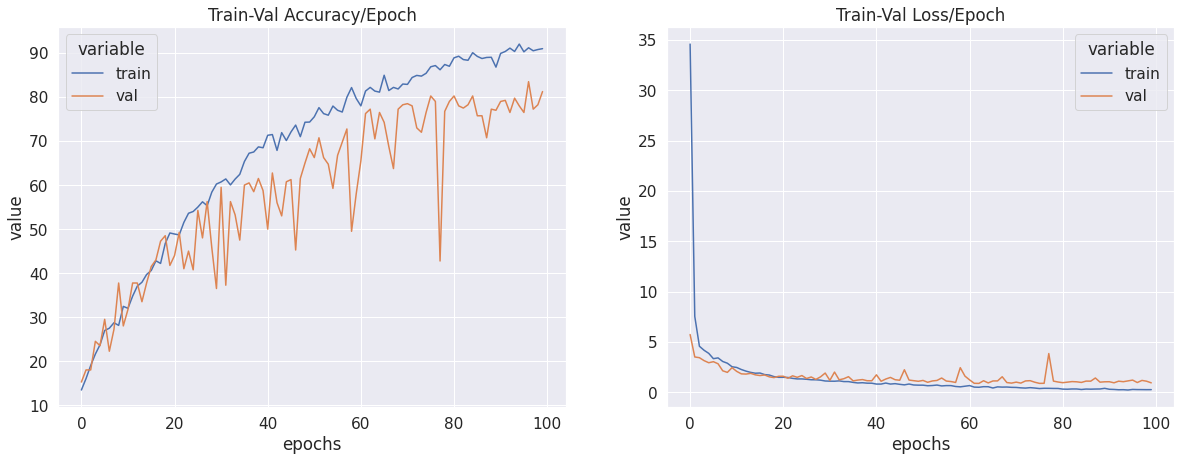

In [ ]:
# Visualize Loss and Accuracy

# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## Testing the Model

In [ ]:
# Test the Model
y_pred_list = []
y_test = []
with torch.no_grad():
    model.eval()
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_test.append(y_batch)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]


In [ ]:
y_testing,y_prediction = [],[]
for i in y_test:
  for one in i:
    y_testing.append(one.tolist().index(1))
for i in y_pred_list:
  for x in i:
    y_prediction.append(x)

# print(len(y_testing) , len(y_prediction))

512 512


## Evaluation Metrics

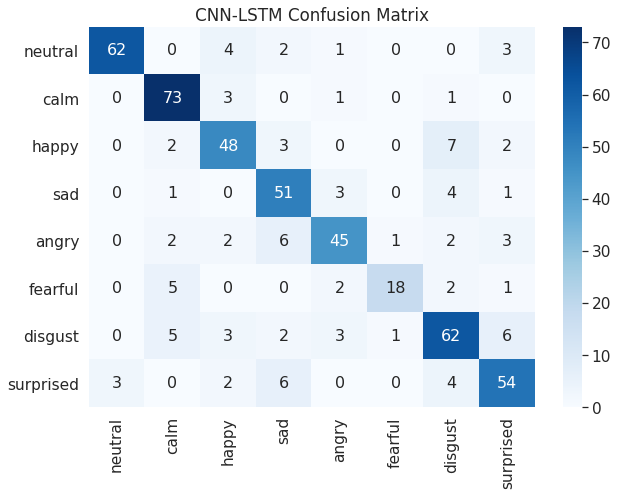

In [ ]:
# Confusion Matrix
emotion = ['neutral','calm','happy','sad','angry','fearful','disgust','surprised']
cm = confusion_matrix(y_testing, y_prediction)
confusion_matrix_df = pd.DataFrame(cm)
names = [emotion[ind] for ind in range(len(emotion))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues').set_title('CNN-LSTM Confusion Matrix') # font size
plt.show()

In [ ]:
# Classification Report and Model Accuracy
classification_report = classification_report(y_testing, y_prediction)
accuracy = accuracy_score(y_testing,y_prediction)
print('Accuracy Score: ',accuracy)
print('Classification Report :\n',classification_report)

Accuracy Score:  0.806640625
Classification Report :
               precision    recall  f1-score   support

           0       0.95      0.86      0.91        72
           1       0.83      0.94      0.88        78
           2       0.77      0.77      0.77        62
           3       0.73      0.85      0.78        60
           4       0.82      0.74      0.78        61
           5       0.90      0.64      0.75        28
           6       0.76      0.76      0.76        82
           7       0.77      0.78      0.78        69

    accuracy                           0.81       512
   macro avg       0.82      0.79      0.80       512
weighted avg       0.81      0.81      0.81       512

